# import libraries

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load and Merge Datasets

In [5]:
# Load datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Aggregate transaction data
transaction_summary = transactions.groupby('CustomerID').agg({
    'Quantity': 'sum',
    'TotalValue': 'sum'
}).reset_index()

# Merge customer profile and transaction summary
customer_data = customers.merge(transaction_summary, on='CustomerID', how='left')

# Handle missing values (if any)
customer_data.fillna(0, inplace=True)

# Display the merged dataset
print(customer_data.head())


  CustomerID        CustomerName         Region  SignupDate  Quantity  \
0      C0001    Lawrence Carroll  South America  2022-07-10      12.0   
1      C0002      Elizabeth Lutz           Asia  2022-02-13      10.0   
2      C0003      Michael Rivera  South America  2024-03-07      14.0   
3      C0004  Kathleen Rodriguez  South America  2022-10-09      23.0   
4      C0005         Laura Weber           Asia  2022-08-15       7.0   

   TotalValue  
0     3354.52  
1     1862.74  
2     2725.38  
3     5354.88  
4     2034.24  


# Preprocess Data

In [7]:
# Select relevant columns for clustering (numerical features)
clustering_data = customer_data[['Quantity', 'TotalValue']]
# Standardize data
scaler = StandardScaler()
clustering_data_scaled = scaler.fit_transform(clustering_data)

# Convert back to DataFrame for easier analysis
clustering_data_scaled = pd.DataFrame(clustering_data_scaled, columns=clustering_data.columns)

# Display scaled data
print(clustering_data_scaled.head())


   Quantity  TotalValue
0 -0.110735   -0.051884
1 -0.434049   -0.862714
2  0.212579   -0.393842
3  1.667493    1.035375
4 -0.919021   -0.769499


# Apply KMeans Clustering

In [8]:
# Determine the optimal number of clusters using the Davies-Bouldin Index
db_scores = []
for k in range(2, 11):  # Clusters from 2 to 10
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(clustering_data_scaled)
    db_index = davies_bouldin_score(clustering_data_scaled, labels)
    db_scores.append((k, db_index))

# Display DB index values for each k
for k, db_index in db_scores:
    print(f"Number of Clusters: {k}, Davies-Bouldin Index: {db_index}")


Number of Clusters: 2, Davies-Bouldin Index: 0.6298644531019864
Number of Clusters: 3, Davies-Bouldin Index: 0.6790773231366432
Number of Clusters: 4, Davies-Bouldin Index: 0.7102764046737506
Number of Clusters: 5, Davies-Bouldin Index: 0.752935057942051
Number of Clusters: 6, Davies-Bouldin Index: 0.8164295471714537
Number of Clusters: 7, Davies-Bouldin Index: 0.7790991322899361
Number of Clusters: 8, Davies-Bouldin Index: 0.8993608517663898
Number of Clusters: 9, Davies-Bouldin Index: 0.8232396439456046
Number of Clusters: 10, Davies-Bouldin Index: 0.8554143386495807


# Choose Optimal Clusters and Fit Model

In [9]:
# Choose the number of clusters with the lowest DB Index
optimal_k = min(db_scores, key=lambda x: x[1])[0]
print(f"Optimal Number of Clusters: {optimal_k}")

# Fit KMeans with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(clustering_data_scaled)

# Display cluster assignments
print(customer_data[['CustomerID', 'Cluster']].head())


Optimal Number of Clusters: 2
  CustomerID  Cluster
0      C0001        1
1      C0002        1
2      C0003        1
3      C0004        0
4      C0005        1


# Calculate Clustering Metrics

In [10]:
# Calculate final Davies-Bouldin Index
db_index_final = davies_bouldin_score(clustering_data_scaled, customer_data['Cluster'])
print(f"Final Davies-Bouldin Index: {db_index_final}")

Final Davies-Bouldin Index: 0.6298644531019864


# Visualize Clusters

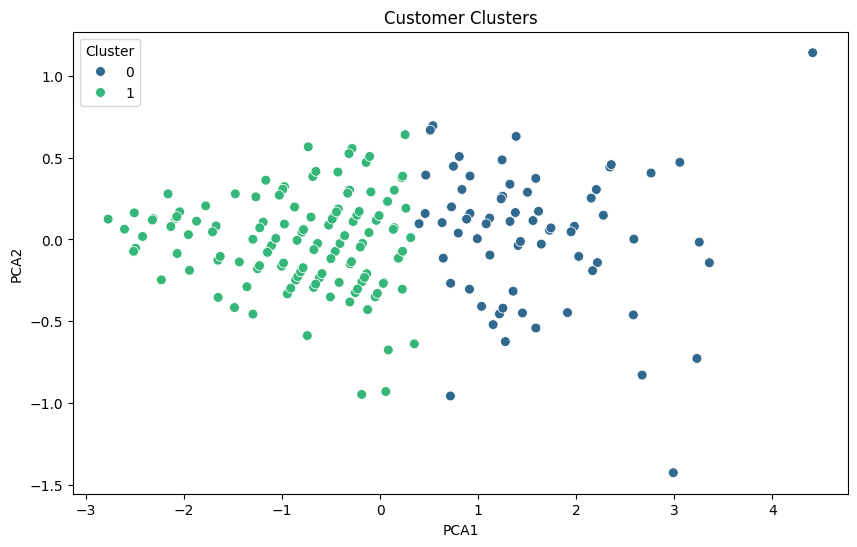

In [11]:
# Visualize clusters in a 2D space using PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(clustering_data_scaled)
customer_data['PCA1'] = reduced_data[:, 0]
customer_data['PCA2'] = reduced_data[:, 1]

# Plot clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='PCA1', y='PCA2', hue='Cluster', data=customer_data, palette='viridis', s=50
)
plt.title('Customer Clusters')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()


# Save result

In [15]:
# Save customer segmentation results to a CSV
customer_data[['CustomerID', 'Cluster']].to_csv('result.csv', index=False)
print("Clustering results saved to 'result.csv'")


Clustering results saved to 'result.csv'
